In [91]:
# ATTACK PLAN
# [X] - show_tensor_images
# [X] - get_generator_block
# [X] - generator - returns image
# [X] - get_noise
# [ ] - get_disc_block
# [ ] - Discrimianator - returns 0-1
# [ ] - data - MNIST
# [ ] - get_disc_loss
# [ ] - train
# [ ] - show_tensor_images(fake)
# [ ] - show_tensor_images(real)



In [92]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torch.functional import F
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim

In [93]:
def show_tensor_images(image_tensor, num_images, size=(1, 28, 28)):
  # print(image_tensor.shape) # torch.Size([10, 1, 28, 28])
  image_tensor = image_tensor.detach().cpu().view(-1, 1, 28, 28)
  # print(image_tensor.shape) # torch.Size([10, 1, 28, 28])
  grid = make_grid(image_tensor[:num_images])
  # print(grid.shape) # torch.Size([3, 28, 28]) for 1 image
  # print(grid.shape) # torch.Size([3, 32, 62]) for 2 image
  # print(grid.shape) # torch.Size([3, 32, 92]) for 3 image

  # image tensor: (C, H, W) -> permute(1,2,0) -> (H, W, C)
  # print(grid.permute(1, 2, 0).shape) # torch.Size([28, 28, 3]) when 1 image
  # print(grid.permute(1, 2, 0).shape) # torch.Size([32, 62, 3]) when 2 image
  # print(grid.permute(1, 2, 0).shape) # torch.Size([32, 92, 3]) when 3 image

  print(grid.permute(1, 2, 0).squeeze().shape) # torch.Size([28, 28, 3]) when one image

  # imshow takes (B, H, W, C)
  plt.imshow(grid.permute(1, 2, 0).squeeze())

  # Confusion: make_grid adds padding and expands W
  # it always uses 3 channels even for grayscale images
  plt.show()

In [94]:
def generator_block(input_dim, output_dim):

  gen_block = nn.Sequential(
      nn.Linear(input_dim, output_dim),
      nn.BatchNorm1d(output_dim),
      nn.ReLU(inplace=True)
  )

  return gen_block

In [95]:
def disc_block(input_dim, output_dim):

  disc_block = nn.Sequential(
      nn.Linear(input_dim, output_dim),
      nn.LeakyReLU(negative_slope=0.2, inplace=True)

  )

  return disc_block

In [96]:
class Generator(nn.Module):
  def __init__(self, z_dim=10, img_dim=28 * 28, hidden_size=128):
    super().__init__()
    self.gen = nn.Sequential(

            generator_block(z_dim, hidden_size),
            generator_block(hidden_size, hidden_size * 2),
            generator_block(hidden_size * 2, hidden_size * 4),
            generator_block(hidden_size * 4, hidden_size * 8),
            nn.Linear(hidden_size * 8, img_dim),
            nn.Sigmoid()

    )

  def forward(self, x):
    return self.gen(x)

In [97]:
class Discriminator(nn.Module):
  def __init__(self, img_dim=28 * 28, hidden_size=128):
    super().__init__()
    self.disc = nn.Sequential(

            disc_block(img_dim, 4 * hidden_size),
            disc_block(hidden_size * 4, hidden_size * 2),
            disc_block(hidden_size * 2, hidden_size),
            nn.Linear(hidden_size, 1)

    )

  def forward(self, x):
    return self.disc(x)

In [98]:
get_noise = lambda n, z_dim, device: torch.randn(n, z_dim).to(device)

In [99]:
def calc_disc_loss(gen, disc,num_images, z_dim, real, criterion, device):

  z = get_noise(num_images, z_dim, device)

  fake = gen(z) # (B, img_dim)

  fake_pred = disc(fake.detach()) # (B, )
  correct_pred = disc(real) # (B, )

  loss_fake = criterion(fake_pred, torch.zeros_like(fake_pred)) # (B, )
  loss_correct = criterion(correct_pred, torch.ones_like(correct_pred)) # (B, )

  avg_loss = (loss_fake + loss_correct) / 2 # (B, )

  return avg_loss

In [100]:
def calc_gen_loss(gen, disc, z_dim, num_images,  device,  criterion):

  z = get_noise(num_images, z_dim, device)

  fake = gen(z) # (B, img_dim)

  fake_pred = disc(fake)

  loss = criterion(fake_pred, torch.ones_like(fake_pred))

  return loss

In [101]:
batch_size = 128
data_train = MNIST('./data', train=True, transform=transforms.ToTensor(),download=True)
data_test = MNIST('./data', train=False, transform=transforms.ToTensor(),download=True)


dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=True)

In [102]:
X, y = next(iter(dataloader_train))

In [103]:
X.shape, y.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [104]:
epochs=200
z_dim=64
lr = 0.00001
display_step=100
device='cuda'




gen = Generator(z_dim=z_dim)
disc = Discriminator()

gen = gen.to(device)
disc = disc.to(device)

optimizer_gen = optim.Adam(gen.parameters(),lr=lr)
optimizer_disc = optim.Adam(disc.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()



torch.Size([62, 242, 3])


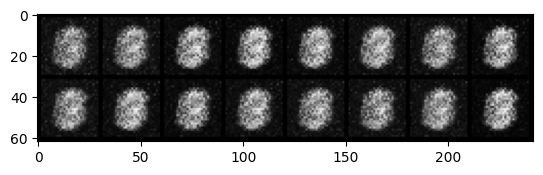

Discriminator Loss: 0.4277 | Generator Loss: 1.3224 | Total Loss: 1.7501
torch.Size([62, 242, 3])


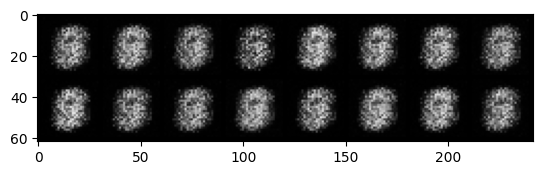

Discriminator Loss: 0.3039 | Generator Loss: 1.6375 | Total Loss: 1.9414
torch.Size([62, 242, 3])


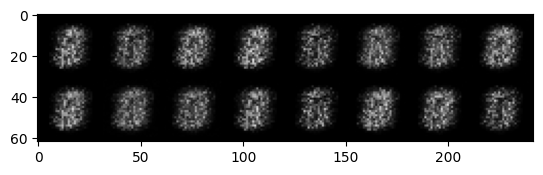

Discriminator Loss: 0.1863 | Generator Loss: 1.8798 | Total Loss: 2.0661
torch.Size([62, 242, 3])


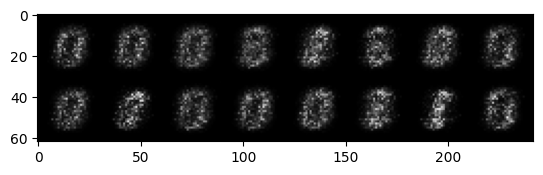

Discriminator Loss: 0.2009 | Generator Loss: 1.7447 | Total Loss: 1.9456
torch.Size([62, 242, 3])


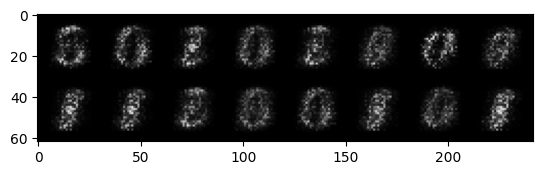

Discriminator Loss: 0.1970 | Generator Loss: 1.7133 | Total Loss: 1.9103
torch.Size([62, 242, 3])


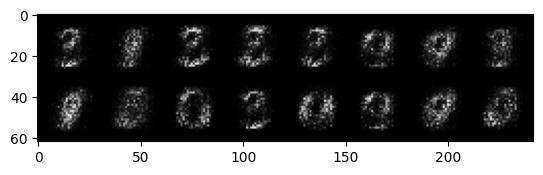

Discriminator Loss: 0.1657 | Generator Loss: 1.9307 | Total Loss: 2.0964
torch.Size([62, 242, 3])


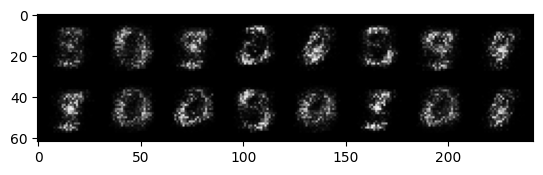

Discriminator Loss: 0.1477 | Generator Loss: 2.1924 | Total Loss: 2.3401
torch.Size([62, 242, 3])


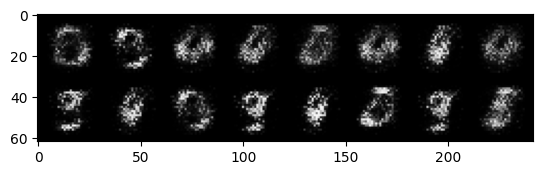

Discriminator Loss: 0.1181 | Generator Loss: 2.6544 | Total Loss: 2.7725
torch.Size([62, 242, 3])


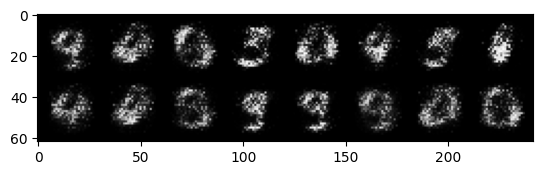

Discriminator Loss: 0.0923 | Generator Loss: 3.0856 | Total Loss: 3.1779
torch.Size([62, 242, 3])


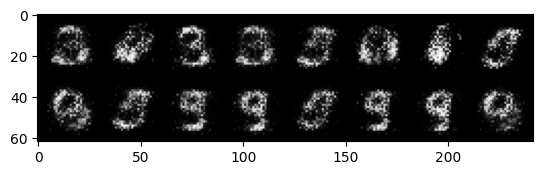

Discriminator Loss: 0.0789 | Generator Loss: 3.3802 | Total Loss: 3.4590
torch.Size([62, 242, 3])


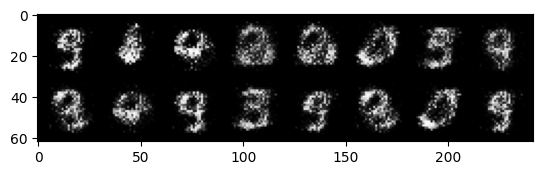

Discriminator Loss: 0.0713 | Generator Loss: 3.6840 | Total Loss: 3.7553
torch.Size([62, 242, 3])


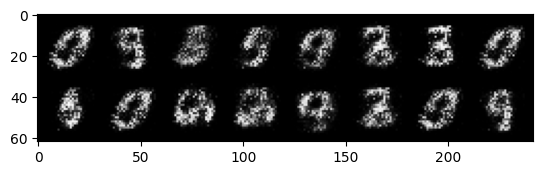

Discriminator Loss: 0.0666 | Generator Loss: 3.7893 | Total Loss: 3.8559
torch.Size([62, 242, 3])


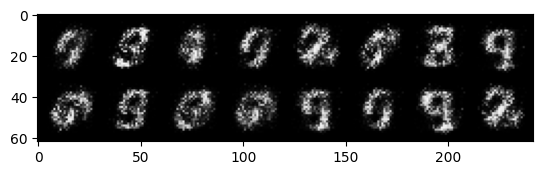

Discriminator Loss: 0.0536 | Generator Loss: 4.0811 | Total Loss: 4.1347
torch.Size([62, 242, 3])


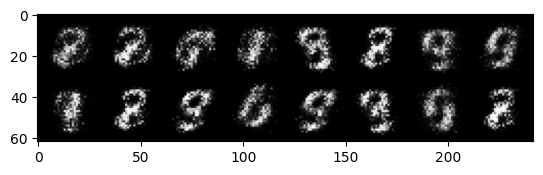

Discriminator Loss: 0.0585 | Generator Loss: 4.4369 | Total Loss: 4.4954
torch.Size([62, 242, 3])


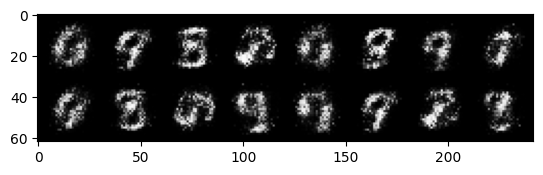

Discriminator Loss: 0.0536 | Generator Loss: 4.1536 | Total Loss: 4.2072
torch.Size([62, 242, 3])


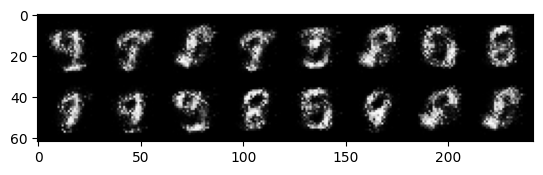

Discriminator Loss: 0.0521 | Generator Loss: 4.2277 | Total Loss: 4.2798
torch.Size([62, 242, 3])


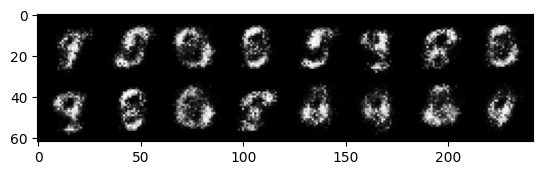

Discriminator Loss: 0.0575 | Generator Loss: 4.1270 | Total Loss: 4.1845
torch.Size([62, 242, 3])


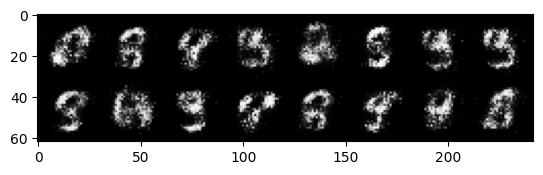

Discriminator Loss: 0.0544 | Generator Loss: 4.1995 | Total Loss: 4.2539


KeyboardInterrupt: 

In [105]:
for epoch in range(epochs):

  running_disc_loss = 0.0
  running_gen_loss = 0.0
  running_total_loss = 0.0
  samples_processed = 0

  for images, labels in dataloader_train:
    images, labels = images.to(device), labels.to(device)

    B, C, H, W = images.shape

    images = images.view(B, -1)

    optimizer_disc.zero_grad()
    disc_loss = calc_disc_loss(gen, disc, B, z_dim, images, criterion, device)
    disc_loss.backward(retain_graph=True)
    optimizer_disc.step()


    optimizer_gen.zero_grad()
    gen_loss = calc_gen_loss(gen, disc, z_dim, B,  device,  criterion)
    gen_loss.backward()
    optimizer_gen.step()


    running_disc_loss += disc_loss.item() * B
    running_gen_loss += gen_loss.item() * B
    running_total_loss += (disc_loss.item() + gen_loss.item()) * B
    samples_processed += B


  z = get_noise(36, z_dim, device)
  img = gen(z)
  show_tensor_images(img, 16)



  disc_loss = running_disc_loss / samples_processed
  gen_loss = running_gen_loss / samples_processed
  total_loss = running_total_loss / samples_processed

  print(f"Discriminator Loss: {disc_loss:.4f} | Generator Loss: {gen_loss:.4f} | Total Loss: {total_loss:.4f}")


